In [10]:
%matplotlib inline
%matplotlib notebook
# %matplotlib qt5

ImportError: Cannot load backend 'Qt5Agg' which requires the 'qt' interactive framework, as 'tk' is currently running

MovieWriter imagemagick unavailable; using Pillow instead.


>>> Current Time: 2,	 Object J: 2.4497, 	 Current u:5.0000, 	 Current Reference: 10, 	 Current System output: 5.1500, 	 Optimization epoch: 50, 	 Solving time:0.6273 s
>>> Current Time: 2,	 Object J: 0.4782, 	 Current u:0.3901, 	 Current Reference: 10, 	 Current System output: 9.0921, 	 Optimization epoch: 100, 	 Solving time:1.2467 s
>>> Current Time: 3,	 Object J: 0.0751, 	 Current u:-0.7587, 	 Current Reference: 10, 	 Current System output: 9.9374, 	 Optimization epoch: 100, 	 Solving time:1.2573 s
>>> Current Time: 4,	 Object J: 0.0744, 	 Current u:1.9005, 	 Current Reference: 10, 	 Current System output: 9.9190, 	 Optimization epoch: 100, 	 Solving time:1.2466 s
>>> Current Time: 5,	 Object J: 0.0002, 	 Current u:1.8027, 	 Current Reference: 10, 	 Current System output: 9.9328, 	 Optimization epoch: 22, 	 Solving time:0.2792 s
>>> Current Time: 6,	 Object J: 0.0001, 	 Current u:1.8391, 	 Current Reference: 10, 	 Current System output: 9.9693, 	 Optimization epoch: 36, 	 Solving ti

>>> Current Time: 52,	 Object J: 0.0000, 	 Current u:0.9091, 	 Current Reference: 5, 	 Current System output: 5.0002, 	 Optimization epoch: 2, 	 Solving time:0.0220 s
>>> Current Time: 53,	 Object J: 0.0000, 	 Current u:0.9091, 	 Current Reference: 5, 	 Current System output: 5.0000, 	 Optimization epoch: 2, 	 Solving time:0.0263 s
>>> Current Time: 54,	 Object J: 0.0000, 	 Current u:0.9091, 	 Current Reference: 5, 	 Current System output: 4.9999, 	 Optimization epoch: 2, 	 Solving time:0.0274 s
>>> Current Time: 55,	 Object J: 0.0000, 	 Current u:0.9091, 	 Current Reference: 5, 	 Current System output: 4.9999, 	 Optimization epoch: 2, 	 Solving time:0.0259 s
>>> Current Time: 56,	 Object J: 0.0000, 	 Current u:0.9091, 	 Current Reference: 5, 	 Current System output: 4.9999, 	 Optimization epoch: 2, 	 Solving time:0.0280 s
>>> Current Time: 57,	 Object J: 0.0000, 	 Current u:0.9091, 	 Current Reference: 5, 	 Current System output: 5.0000, 	 Optimization epoch: 2, 	 Solving time:0.0256 

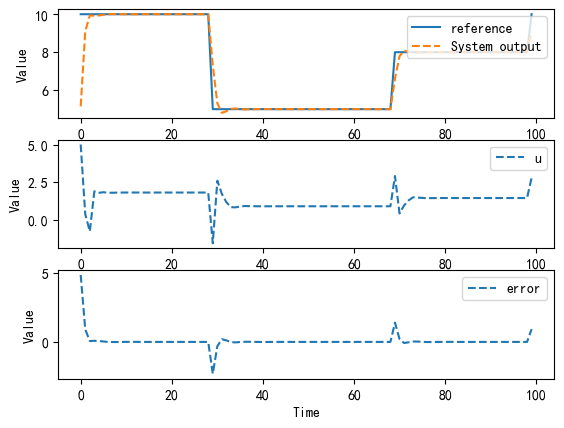

In [11]:

''' test bp-mpc'''
import pandas as pd



if __name__ == '__main__':
    import numpy as np
    import matplotlib.pyplot as plt
    from tensorflow.keras.models import load_model
    import tensorflow as tf
    from src.dlmpc import SimSISO
    from src.dlmpc import DeepLearningMPCController
    from src.dlmpc import optimizer
    from src.dlmpc import OnlineOptimize
    import time
    import os
    import matplotlib as mpl
    from matplotlib.animation import FuncAnimation, ImageMagickWriter
    mpl.use('TkAgg')
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    plt.tick_params(labelsize=12)

    # TODO: Step1: parameters Settings
    #  NN parametes Settings
    # 窗口大小
    input_window_dy = 2
    input_window_du = 2
    ly = input_window_dy  # y的历史状态的长度
    lu = input_window_du-1  # u的历史输入的长度
    dim = ly+lu

    # MPC parameters Settings
    # Train_NN = True
    Train_NN = False
    mpc = True
    predict_horizon = 4 #10  # 预测时域  (2,1), (4,2 *),(3,3)
    control_horizon = 2 #5   # control_horizon
    dim_u = 1             # control variable dimension = 1
    du_bounds = 10       # control variable constraints (delta u)
    u_bounds = [-5,5]          # control variable constraints (u)
    opt = optimizer(optimizer_name='sgd', learning_rate=0.1, du_bound=None, exponential_decay=False)
    error = 0

    # 定义权重矩阵
    Q = np.eye(predict_horizon) * 0.1   # 跟踪误差的权重矩阵  # 0.1
    R = np.eye(control_horizon) * 0.01  # 控制输入的权重矩阵 # 0.01

    N = 50  # 运行周期
    y_ref = 10  # 参考轨迹值
    # 初始化系统状态
    '''
    initial_state = np.array([1, 1.2])    # 初始状态可以自定义，y[0]，y[1]
    initial_input = np.array([0.1, 0.2])  # 初始状态可以自定义，u[0],u[1]
    '''
    state_y = tf.constant([[1], [1.2]], dtype=tf.float32)
    state_u = tf.constant([[0.1]], dtype=tf.float32)
    u0 = tf.constant([0.2], dtype=tf.float32)


    # TODO: Step2: load plant and parameters
    '''return plant: simulation'''
    simulation = SimSISO(noise_amplitude=0)

    # TODO: Step3: Load  NN model and training
    if Train_NN:
        '''get trained model'''
        import os
        script_path = 'test_models_bp_regressor.py'
        os.system(f'python {script_path}')

    model = load_model(f'models_save/BP_predictor.h5')
    # model.summary()

    # TODO: Step4: mpc training

    if mpc:

        mpc_controller = DeepLearningMPCController(model, predict_horizon, control_horizon, Q, R, ly, lu, dim_u,
                                                   [du_bounds, du_bounds], u_bounds, opt)

        # 创建数据存储和图表
        data = np.zeros((N - 2, 7))
        result = pd.DataFrame(data,
                              columns=['Time', 'reference', 'System output', 'u', 'solving_time', 'epoch', 'error'])
        plt.close()
        fig, ax = plt.subplots(3, 1)
        plt.ion()  # 打开交互模式
        # 初始化图表的线条对象
        line_reference, = ax[0].plot([], [], label='reference')
        line_system_output, = ax[0].plot([], [], '--', label='System output')
        line_u, = ax[1].plot([], [], '--', label='u')
        line_error, = ax[2].plot([], [], '--', label='error')
        r = []
        s = []
        u = []
        e = []
        # 为图表设置图例和标签
        for a in ax:
            a.legend(loc='upper right')
            a.set_ylabel('Value')
            a.set_xlabel('Time')

        # 定义更新图表的函数
        # 动画更新函数
        def update(frame):
            global u0,state_y,state_u, result
            # 这里模拟了您的MPC控制和系统输出更新
            if frame < 30:
                y_ref = 10
            elif frame>=30 and frame < 70:
                y_ref = 5
            elif frame>=70 and frame < 100:
                y_ref = 8
            else:
                y_ref = 10
            # 假设OnlineOptimize是已定义的函数，用于创建MPC实例
            mpc = OnlineOptimize(mpc_controller, state_y, state_u)
            # controller computation
            parameter = mpc.make_step(u0, y_ref, iterations=100, tol=1e-6, init_u=False)
            u0 = parameter['u0']
            # system output
            plant_output = simulation.plant(np.append(tf.squeeze(state_u), parameter['u0']), tf.squeeze(state_y))
            # estimate state
            state_y, state_u = mpc.estimate(parameter['u0'], plant_output, use_online_correction=True)
            print(
                f">>> Current Time: {frame},\t Object J: {parameter['solving_J']:>=.4f}, \t Current u:{parameter['u0'][0]:>=.4f}, \t Current Reference: {y_ref}, \t Current System output: {plant_output[0]:>=.4f}, \t Optimization epoch: {parameter['solving_epoch']}, \t Solving time:{parameter['solving_time']:>=.4f} s")

            # 记录数据
            result.at[frame, 'Time'] = frame
            result.at[frame, 'reference'] = y_ref
            result.at[frame, 'System output'] = plant_output[0]
            result.at[frame, 'u'] = parameter['u0'][0]
            result.at[frame, 'solving_time'] = parameter['solving_time']
            result.at[frame, 'epoch'] = parameter['solving_epoch']
            result.at[frame, 'error'] = y_ref - plant_output[0]

            # 更新图表数据
            r.append(np.array(result['reference'][frame:frame + 1])[0])
            s.append(np.array(result['System output'][frame:frame + 1])[0])
            u.append(np.array(result['u'][frame:frame + 1])[0])
            e.append(np.array(result['error'][frame:frame + 1])[0])


            line_reference.set_data([i for i in range(len(r))],r)
            line_system_output.set_data([i for i in range(len(s))],s)
            line_u.set_data([i for i in range(len(u))],u)
            line_error.set_data([i for i in range(len(e))],e)

            # 调整y轴范围以适应数据
            for a in ax:
                a.relim()
                a.autoscale_view()

            return line_reference, line_system_output, line_u, line_error


        # # 创建动画对象
        animation = FuncAnimation(fig, update,
                                            frames=range(2,100),  # total 100 frames
                                            interval=200,  # 20 frames per second
                                            blit=False,repeat=False)
        animation.save('sinx.gif', writer='imagemagick')
        # plt.show()
        # plt.ioff()  # This line is not needed and can be removed
        # anim = FuncAnimation(fig, update, frames=range(2,100), blit=False)

        # # 打印结果和描述（可选）
        # print(result)
        # print(result.describe())
        #
        #
        # plt.figure()
        # plt.plot(result['reference'], '-', label='reference')  # 绘制当前变量的数据
        # plt.plot(result['System output'], '--', label='System output')  # 绘制当前变量的数据
        # plt.legend(loc='upper right')
        # plt.show()
        #
        # os.getcwd()


